In [1]:
# Memanggil semua library yang dibutuhkan
import json, tweepy, re, string, nltk, pandas as pd, numpy as np, matplotlib.pyplot as plt, datetime, seaborn as sns
from requests_oauthlib import OAuth1
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from urllib.request import urlopen
from bs4 import BeautifulSoup
from wordcloud import WordCloud


In [2]:
# Membuka file token.json
with open("token.json") as f:
    tokens = json.load(f)

    api_key = tokens["api_key"]
    api_key_secret = tokens["api_key_secret"]
    bearer_token = tokens["bearer_token"]
    access_token = tokens["access_token"]
    access_token_secret = tokens["access_token_secret"]


In [3]:
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.Client(bearer_token=bearer_token, wait_on_rate_limit=True)

In [4]:
# Melakukan scrapping data menggunakan tweepy v2
query = "pssi -is:retweet lang:id"
max_result = 300
response = tweepy.Paginator(api.search_recent_tweets,
                            query=query,
                            start_time=datetime.datetime(2023, 1, 20, 0, 0, 0),
                            end_time=datetime.datetime(2023, 1, 22, 0, 0, 0),
                            max_results=100
                            ).flatten(limit=max_result)

In [5]:
# mengambil isi data pada variabel response
tweets = [tweet.text.strip() for tweet in response] 
data_1 = pd.DataFrame({"text":tweets})
data_1

,text
0,"@PSSI mantap.,. pelatih, pemain smua naturalis..."
1,Proses Verifikasi Bakal Petinggi PSSI Diumumka...
2,@wirasatriap23 @SekarPandann @BlueHooligan___ ...
3,@aundragdown @PSSleman Nek moro-moro ono wkwkw...
4,Tegas! Madura United Tolak Berikan Suara kepad...
...,...
295,@panditfootball Ujung muaranyA di PSSI nah bap...
296,"@SiaranBolaLive Intinya semuanya tolol, mau ps..."
297,@ibamhariri Lagian udh tahu akun anonim pake d...
298,Sing ora due pendidikan tulih koe su asu @PSSI...


In [6]:
# Scrapping data dari web menggunakan BeautifulSoup
url = "https://www.detik.com/tag/pssi"
html = urlopen(url)
data = BeautifulSoup(html, 'html.parser')

divs = data.find_all("h2", {"class":"title"})
berita = []
for div in divs:
    berita.append(div.get_text())

data_2 = pd.DataFrame({"text":berita})
data_2

,text
0,El Clasico PSSI Erick Vs La Nyalla
1,Menpora Minta Doa untuk Kesembuhan Eks Ketum P...
2,La Nyalla: Industri Sepakbola Indonesia Harus ...
3,"Park Hang-seo Bantah Latih Timnas Indonesia, P..."
4,Manuver Erick Thohir Saingi La Nyala Daftar Ca...
5,Dewa United Dukung Lexyndo Hakim Jadi Anggota ...
6,Ketua Asprov PSSI Jatim Ungkap Ada Klub Liga 1...
7,Coretan 'PSSI Bangsat' Muncul di Medan Buntut ...
8,Poster 'Daur Ulang PSSI' Tersebar di Makassar ...
9,"Jadi Balon Anggota Exco PSSI, Monica Mau Perju..."


In [7]:
# Menggabungkan data_1 dan data_2
df = data_1.append(data_2, ignore_index=True)
df

,text
0,"@PSSI mantap.,. pelatih, pemain smua naturalis..."
1,Proses Verifikasi Bakal Petinggi PSSI Diumumka...
2,@wirasatriap23 @SekarPandann @BlueHooligan___ ...
3,@aundragdown @PSSleman Nek moro-moro ono wkwkw...
4,Tegas! Madura United Tolak Berikan Suara kepad...
...,...
305,Dewa United Dukung Lexyndo Hakim Jadi Anggota ...
306,Ketua Asprov PSSI Jatim Ungkap Ada Klub Liga 1...
307,Coretan 'PSSI Bangsat' Muncul di Medan Buntut ...
308,Poster 'Daur Ulang PSSI' Tersebar di Makassar ...


In [8]:
# Fungsi Case Folding untuk membersihkan text 
def case_folding(data):
    data = data.lower() # menjadikan text lowercase
    data = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",data).split()) # menghilangkan karakter @ dan url
    data = re.sub(r"\d+", "", data) # menghapus angka
    data = data.translate(str.maketrans("","",string.punctuation)) # menghapus tanda baca
    data = re.sub(r"\n","",data) # menghapus enter
    data = re.sub(r"\t","",data) # menghapus tab
    return data

# Fungsi stopword_cleaner untuk menghilangkan kata-kata yang tidak terpakai atau banyak digunakan
def stopword_cleaner(data):
    sw_indonesia = stopwords.words("indonesian") + ['pssi','yg','ya','nya','aja','ga','gak']
    data  = [word for word in data if word not in sw_indonesia]
    data = ' '.join(data)
    return data
    
# Fungsi stem_word untuk mengubah kata menjadi kata dasar
def stem_word(data):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    data = stemmer.stem(data)
    return data

In [9]:
# Membuat kolom review dan mengaplikasikan fungsi-fungsi diatas pada kolom review
df['review'] = df['text']
for index in range (len(df["review"])):
  df["review"].iloc[index] = case_folding(df["review"].iloc[index])
  df["review"].iloc[index] = word_tokenize(df["review"].iloc[index])
  df["review"].iloc[index] = stopword_cleaner(df["review"].iloc[index])
  df["review"].iloc[index] = stem_word(df["review"].iloc[index])

df

,text,review
0,"@PSSI mantap.,. pelatih, pemain smua naturalis...",mantap latih main smua naturalisasi min mudah ...
1,Proses Verifikasi Bakal Petinggi PSSI Diumumka...,proses verifikasi petinggi umum januari
2,@wirasatriap23 @SekarPandann @BlueHooligan___ ...,siga nu teu terang wae ah wkwkwk sakitu kuatka...
3,@aundragdown @PSSleman Nek moro-moro ono wkwkw...,nek moro moro ono wkwkwk omong ki koyo maratab...
4,Tegas! Madura United Tolak Berikan Suara kepad...,madura united tolak suara nama maju urus halam...
...,...,...
305,Dewa United Dukung Lexyndo Hakim Jadi Anggota ...,dewa united dukung lexyndo hakim anggota exco
306,Ketua Asprov PSSI Jatim Ungkap Ada Klub Liga 1...,ketua asprov jatim klub liga suporter
307,Coretan 'PSSI Bangsat' Muncul di Medan Buntut ...,coret bangsat muncul medan buntut liga henti
308,Poster 'Daur Ulang PSSI' Tersebar di Makassar ...,poster daur ulang sebar makassar jelang klb


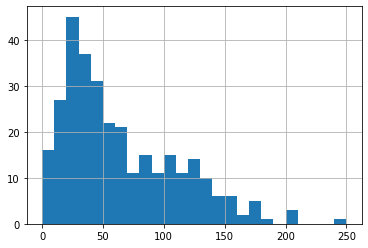

In [10]:
# Distribusi Frekuensi jumlah huruf per data
bin_range = np.arange(0, 260, 10)
df['review'].str.len().hist(bins=bin_range)
plt.show()

Distribusi terbanyak berada pada 10 - 70 huruf per kalimat. Dengan kalimat yang memiliki panjang diatas 20 huruf.

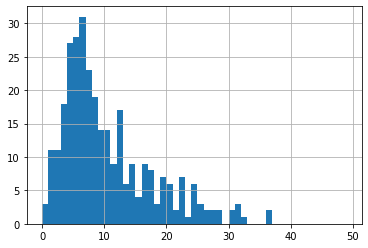

In [11]:
# Distribusi frekuensi jumlah kata per data
bin_range = np.arange(0, 50)
df['review'].str.split().map(lambda x: len(x)).hist(bins=bin_range)
plt.show()

Distribusi terbanyak berada pada 4 - 10 kata per kalimat. Kalimat dengan jumlah kata diatas 13 tidak terlalu banyak

c:\Users\asus\AppData\Local\Programs\Python\Python38-32\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\asus\AppData\Local\Programs\Python\Python38-32\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


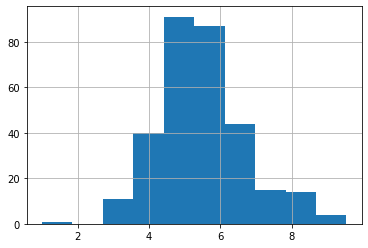

In [12]:
# Distribusi Frekuensi Panjang Kata Rata-Rata Pada Data
df['review'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
plt.show()

Distribusi terbanyak berada pada 5 - 7 karakter per kata per tweet. Jumlah huruf pada kata yang umum ada pada bahasa indonesia. 

In [13]:
# Distribusi Frekuensi Kata yang sering keluar
token_review = df['review'].apply(lambda x: word_tokenize(str(x)))
tweets = [word for tweet in token_review for word in tweet]
fqdist = FreqDist(tweets)
most_common_word = fqdist.most_common(20)
print(most_common_word)

[('erick', 49), ('thohir', 45), ('indonesia', 37), ('ketua', 33), ('liga', 32), ('didik', 32), ('bola', 31), ('suporter', 31), ('sepakbola', 30), ('kalo', 30), ('butuhnyalibukannyala', 29), ('main', 25), ('tum', 21), ('sepak', 19), ('calon', 18), ('orang', 17), ('klub', 16), ('urus', 15), ('salah', 15), ('pilih', 14)]


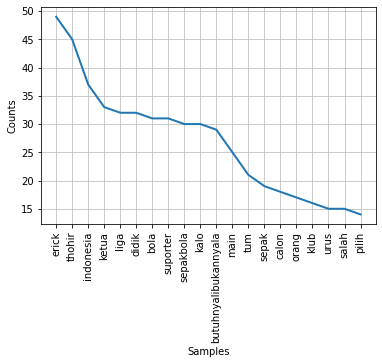

In [14]:
fqdist.plot(20,cumulative=False)
plt.show()

Distribusi kata yang sering keluar terdapat pada kata erick, thohir, dan indonesia dengan frekuensi kemunculan diatas 35 kali.

In [15]:
# Distribusi N-gram
result = pd.Series(nltk.ngrams(tweets, 2)).value_counts()[:20]
print(result)

(erick, thohir)                             45
(sepak, bola)                               19
(sepakbola, indonesia)                      11
(calon, ketua)                              11
(liga, indonesia)                            7
(ketua, erick)                               6
(bola, indonesia)                            6
(pilih, ketua)                               5
(menteri, bumn)                              5
(amal, mundur)                               5
(butuhnyalibukannyala, bangkitbersamaet)     5
(prestasi, olahraga)                         4
(gas, air)                                   4
(restu, presiden)                            4
(air, mata)                                  4
(main, turun)                                4
(bolasport, arenanews)                       4
(halaman, bolasport)                         4
(zainudin, amal)                             4
(arenanews, kamidi)                          4
dtype: int64


Berdasarkan bigram diatas, dapat disimpulkan bahwa isu dan topik yang sedang hangat dibicarakan adalah tentang pemilihan ketua dimana erick tohir merupakan calon ketua yang paling banyak dibicarakan, restu yang diberikan presiden, sepak bola di Indonesia, dan liga Indonesia.

In [16]:
# Membuka file kata_positif.txt dan kata_negatif.txt sebagai referensi pengelompokan sentiment
with open("kata_positif.txt","r") as positif_file :
  positive_words = list(set(positif_file.readlines()))
with open("kata_negatif.txt","r") as negative_file :
  negative_words = list(set(negative_file.readlines()))

In [17]:
tweetss = list(df["review"])
hasil = []
list_negasi = ['tidak','lawan','anti', 'tdk', 'jangan', 'gak', 'enggak', 'bukan', 'tak']

for tweet in tweetss:

    tweet_clean = tweet.strip().split()
    
    good_count = 0 #nilai positif
    bad_count = 0 #nilai negatif

    for good_word in positive_words:
        count = tweet_clean.count(good_word.strip().lower())
        if count > 0:
          good_count += count

    for bad_word in negative_words:
        count = tweet_clean.count(bad_word.strip().lower())
        if count > 0:
          bad_count += count
    
    hasil.append(good_count - bad_count)

In [18]:
# Jika nilai hasil > 0 maka sentiment positif, jika = 0 maka sentiment netral, jika < 0  maka sentiment negatif
sentiments = ["positif" if sentimen > 0 else ("netral" if sentimen == 0 else "negatif") for sentimen in hasil]
df["sentiment"] = sentiments # membuat kolom sentiment, diisi dengan hasil dari variabel sentiments
df

,text,review,sentiment
0,"@PSSI mantap.,. pelatih, pemain smua naturalis...",mantap latih main smua naturalisasi min mudah ...,positif
1,Proses Verifikasi Bakal Petinggi PSSI Diumumka...,proses verifikasi petinggi umum januari,netral
2,@wirasatriap23 @SekarPandann @BlueHooligan___ ...,siga nu teu terang wae ah wkwkwk sakitu kuatka...,netral
3,@aundragdown @PSSleman Nek moro-moro ono wkwkw...,nek moro moro ono wkwkwk omong ki koyo maratab...,netral
4,Tegas! Madura United Tolak Berikan Suara kepad...,madura united tolak suara nama maju urus halam...,positif
...,...,...,...
305,Dewa United Dukung Lexyndo Hakim Jadi Anggota ...,dewa united dukung lexyndo hakim anggota exco,netral
306,Ketua Asprov PSSI Jatim Ungkap Ada Klub Liga 1...,ketua asprov jatim klub liga suporter,netral
307,Coretan 'PSSI Bangsat' Muncul di Medan Buntut ...,coret bangsat muncul medan buntut liga henti,negatif
308,Poster 'Daur Ulang PSSI' Tersebar di Makassar ...,poster daur ulang sebar makassar jelang klb,netral


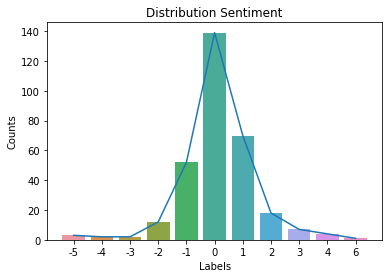

In [19]:
# Plot distribusi sentiment
labels, counts = np.unique(hasil, return_counts=True)

fig, ax = plt.subplots()
ax.set_xticks(ax.get_xticks())

sns.barplot(x = list(labels), 
            y = list(counts))

sns.lineplot(x = ax.get_xticks(), 
            y = list(counts))

plt.title(f'Distribution Sentiment')
plt.xlabel('Labels')
plt.ylabel('Counts')

plt.show()

Dari gambar diatas maka data sentiment ini termasuk distribution normal

<AxesSubplot:ylabel='sentiment'>

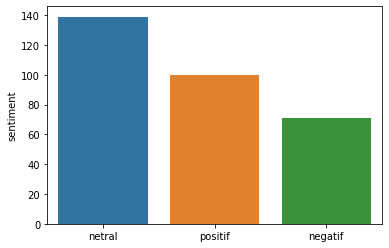

In [20]:
# Plot jumlah nilai untuk kategori positif, netral, dan negatif
sns.barplot(x=df['sentiment'].value_counts().index, y=df['sentiment'].value_counts())

Dari gambar diatas terlihat bahwa lebih banyak sentiment positif dari pada sentiment negatif. Tetapi disamping itu lebih banyak yang memberikan opini netral.

In [21]:
df.to_csv('pssi.csv')